#### Import Necessary Libraries

In [1]:
import copy
from typing import Any, Tuple, Dict, Optional

import numpy as np
import gymnasium as gym
from gymnasium import spaces

#### Value function Policy Plot

In [2]:
import matplotlib.pyplot as plt
import numpy as np


def value_function_policy_plot(V, policy, env_map):
    plt.figure(figsize=(7, 7))
    plt.imshow(V, cmap='viridis', interpolation='none')  # , clim=(0, 1)
    ax = plt.gca()
    ax.set_xticks(np.arange(V.shape[0]) - .5)
    ax.set_yticks(np.arange(V.shape[1]) - .5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    for y in range(V.shape[0]):
        for x in range(V.shape[1]):
            # Plot value
            plt.text(x-0.25, y+0.35, format(V[y, x], '.2f'),
                     color='white', size=12, verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            # Plot map
            plt.text(x - 0.25, y - 0.25, str(env_map[y][x]),
                     color='white', size=12, verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            # Plot policy
            for i, prob in enumerate(policy[y, x]):
                dx = 0.0
                dy = 0.0
                if i == 0:  # Up
                    dy = -prob / 3.0
                elif i == 1:  # Right
                    dx = prob / 3.0
                elif i == 2:  # Down
                    dy = prob / 3.0
                elif i == 3:  # Left
                    dx = -prob / 3.0
                if dx == 0.0 and dy == 0.0:
                    pass
                plt.arrow(x, y, dx, dy, width=0.01, color='black')

    plt.grid(color='black', lw=1, ls='-')
    plt.colorbar()
    plt.show()

In [3]:
def clamp(v, minimal_value, maximal_value):
    return min(max(v, minimal_value), maximal_value)

#### Defining the Grid world class

In [4]:
class GridWorldEnv(gym.Env):
    def __init__(self):
        self.map = [
            list("s   "),
            list("    "),
            list("    "),
            list("gt g"),
        ]
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=4, shape=(2,), dtype=np.int32)
        self.agent_position = [0, 0]
    
    def reset(
            self,
            *,
            seed: Optional[int] = None,
            options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.agent_position = [0, 0]
        return self._observe(), {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, Any]]:
        assert self.action_space.contains(action)
        match action:
            case 0:
                self.agent_position[0] -=1
            case 1:
                self.agent_position[1] +=1
            case 2:
                self.agent_position[0] +=1
            case _:
                self.agent_position[1] -=1
        
        self.agent_position[0] = clamp(self.agent_position[0], 0, 3)
        self.agent_position[1] = clamp(self.agent_position[1], 0, 3)

        observation  = self._observe()
        reward, done = 0, False 
        if 't' == self.map[self.agent_position[0]][self.agent_position[1]]:
            reward, done = -1, True
        if 'g' == self.map[self.agent_position[0]][self.agent_position[1]]:
            reward, done = +1, True
        return observation, reward, done, False, {}

    def render(self):
        rendered_map = copy.deepcopy(self.map)
        rendered_map[self.agent_position[0]][self.agent_position[1]] = "A"
        print("_________")
        for row in rendered_map:
            print("|", end='')
            for cell in row:
                print("{}|".format(cell),end='')
            print()
        print("---------")
        return None
    
    def close(self):
        pass

    def _observe(self):
        return np.array(self.agent_position)
           

#### Defining the TD world Class

In [5]:
class TDAgent:
    def __init__(self, env, discount_factor, learning_rate):
        self.env = env
        self.g = discount_factor
        self.lr = learning_rate

        self.num_actions = env.action_space.n

        # V[y, x] is value for grid position y, x, initialize to all zeros
        self.V = np.zeros(env.observation_space.high, dtype=np.float32)

        # uniform random policy[y, x, z], i.e. probability of action z when in grid position y, x is 1 / num_actions
        self.policy = np.ones((*env.observation_space.high, self.num_actions), dtype=np.float32) / self.num_actions

        # partially deterministic policy:
        self.policy[1, 0], self.policy[1, 0, 2] = 0.0, 1.0  # Down with 100%
        self.policy[2, 0], self.policy[2, 0, 2] = 0.0, 1.0  # Down with 100%
        self.policy[1, 1], self.policy[1, 1, 2] = 0.0, 1.0  # Down with 100%
        self.policy[2, 1], self.policy[2, 1, 2] = 0.0, 1.0  # Down with 100%

    def action(self, s):
        return np.random.choice(np.arange(self.num_actions), p=self.policy[*s])  # action sampled following policy

    def learn(self, n_timesteps=50000):
        s, _ = self.env.reset()

        for i in range(n_timesteps):
            a = self.action(s)  # Select action following the policy
            s_, r, terminated, _, _ = self.env.step(a)   # Observe the next state and the reward
            self.update(s, r, s_)   # You will have to call self.update(...) at every step
            s = s_  # Update state
            if terminated:  # Do not forget to reset the environment if you receive a 'terminated' signal
                s, _ = self.env.reset()

    def update(self, s, r, s_):
        # V(s) <- V(s) + alpha * (r + gamma * V(s') - V(s))
        self.V[*s] = self.V[*s] + self.lr * (r + self.g * self.V[*s_] - self.V[*s])

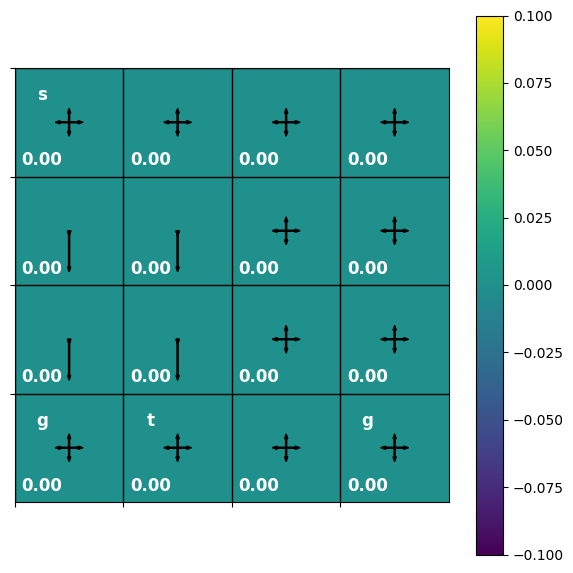

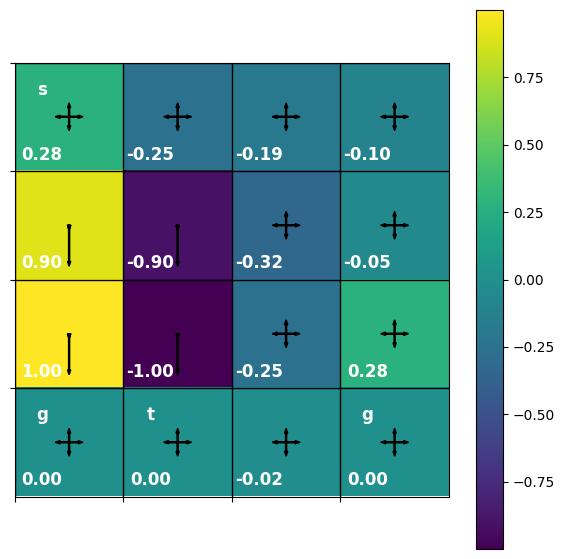

In [7]:
if __name__ == "__main__":
    # Create Agent and environment
    td_agent = TDAgent(GridWorldEnv(), discount_factor=0.9, learning_rate=0.01)

    value_function_policy_plot(td_agent.V, td_agent.policy, td_agent.env.map)

    # Learn the state-value function for 100000 steps
    td_agent.learn(n_timesteps=100000)

    # Visualize V
    value_function_policy_plot(td_agent.V, td_agent.policy, td_agent.env.map)